_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2022

Name: Kathrin Root, Alexander Wendt, Patrick Weygoldt

# Coding Lab 8



In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rc("savefig", dpi=72)
sns.set_style('whitegrid')
%matplotlib inline

## Task: Implement entropy estimators




### General framework

Entropy is defined as 

$$
H[p] = -\sum_x p_x \log p_x
$$

where $p_x = p(x=X)$. Here we assume that $X$ is a discrete random variable and that there are finitely many states $K$ that $X$ can take.

We are interested in the entropy of discrete random variables, because of its relationship with mutual information:

$$
I[X|Y] = H[X] - H[X|Y]
$$

If we can estimate the entropy well, we can estimate the mutual information well. An application in neuroscience would be estimating the mutual information between a spike train modeled as a sequence of $1$ s and $0$ s (e.g. $(0,1,0,1,1)$) and a discrete set of stimuli.

Note that a multivariate binary distribution modeling a spike train can always be mapped to a discrete univariate distribution, $\mathbb{Z}_2 \longrightarrow \mathbb{Z_+}$, by interpreting each binary state $z \in \mathbb{Z}_2$ as its corresponding binary number and computing $f(z) = \sum_i 2^{i} z_i$.

As discussed in the lecture, the problem is that one always underestimates the true entropy of a distribution from samples. In this exercise you are meant to implement different estimators for discrete entropy and evaluate them on different discrete distributions:

* Uniform distribution: 
$$p(x=X) = \frac{1}{K}$$

* "Zipf's law"- distribution: 
$$p(x=X) = \frac{1}{Z x}$$
where 
$$Z = \sum_k 1/k$$

There is a really good series of blog posts about discrete entropy estimation to be found [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-1.html), [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-2.html) and [here](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-3.html). 

Make sure you use binary logarithms throughout.


### Implementation of the estimators

Implement the

* maximum likelihood estimator (1 pt)
* miller-maddow corrected estimator (1 pt)
* jack-knife corrected estimator (2 pt)
* coverage adjusted estimator (1 pt).

When implementing the jack-knife estimator, you may want to restrict the amount of resampling for performance reasons e.g. to 1000, even if more samples are available. 

By definition, $0\log0=0$. Adapt the interfaces as needed for your implementation.

In addition, implement or use one of the following more advanced estimators (1+3 pts, extra points if you use your own implementation):

* [JVHW estimator](https://arxiv.org/abs/1406.6956) with code on [github](https://github.com/EEthinker/JVHW_Entropy_Estimators/tree/master/Python)
* [Unseen estimator](http://papers.nips.cc/paper/5170-estimating-the-unseen-improved-estimators-for-entropy-and-other-properties) (includes Matlab code in Supplementary)
* [Best Upper Bounds estimator](http://www.mitpressjournals.org/doi/abs/10.1162/089976603321780272) (Matlab code available on Ilias)

For this part, you are allowed to use an existing implementation as well.


## MLE

$$H_{ML}= -\sum_{x}\hat{p}(x)log(\hat{p}(x))$$

In [2]:
def entropy_mle(phat):
    '''Maximum likelihood or plug-in estimator of discrete entropy
    
    Parameter
    ---------
    
    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram
    
    Return
    ------
    H: float
        Entropy estimate
    '''
    # insert your code here (1 pt)
    # where is phat zero, calulate with 0log0 = 0
    H = -np.sum([p * np.log2(p) if p != 0 else 0 for p in phat])
    return H


## Miller-Maddow corrected

$$H_{MM}=H_{ML}+\frac{\hat{d}-1}{2n}$$

$$\hat{d} = \#[\hat{p}(x)>0]$$



In [3]:
def entropy_mm(phat, n):
    '''Miller-Maddow corrected estimator of discrete entropy
    
    Parameters
    ----------
    
    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram
        
    n:  int
        Number of samples
    

    Return
    ------
    
    H: float
        Entropy estimate
    '''

    # insert your code here (1 pt)
    dhat = np.sum(phat > 0)
    H = entropy_mle(phat) + (dhat - 1) / (2 * n)
    
    return H


## Jack-knife corrected

$$\hat{H}_{JK} = N\hat{H}_{ML} - (N-1)\hat{H}_{ML}^{(.)}$$

$$\hat{H}_{ML}^{(.)} = <H_{ML}^{\lnot i}>$$

In [4]:
def entropy_jk(x, edges, max_resamples=1000):
    '''Jack-knife corrected estimator of discrete entropy
    
    Parameters
    ----------
    x: np.array, shape=(n_samples, )
        Samples
        
    edges: np.array, shape=(n_bins, )
        Histogram bin edges
    
    max_resamples: int, optional (default=1000)
        Maximum number of resamples to use for the jack-knife estimator
    
    
    Return
    ------
    
    H: float
        Entropy estimate
    '''
    if len(x) > 1000:
        max_resamples = 1000
    else:
        max_resamples = len(x)
    phat = np.histogram(x, bins=edges)[0] / len(x)
    n = len(x)
    H_forloop = np.zeros(max_resamples)
    for i in range(max_resamples):
        x_i = np.delete(x, i)
        phat_i = np.histogram(x_i, bins=edges)[0] / (n - 1)
        H_i = entropy_mle(phat_i)
        H_forloop[i]= H_i
    H_dot = np.mean(H_forloop)
    
    H = n * entropy_mle(phat) - (n - 1) * H_dot
    return H

## Coverage-adjusted

$$C = 1 - \frac{\# f_{i}=1}{N}$$

$$\hat{P}_{C}= \hat{P}\cdot C$$

$$H_{CA}= -\sum_{x}\frac{\hat{P_{C}}(x)log(\hat{P_{C}}(x))}{1-(1-\hat{P_{C}}(x))^N}$$



In [5]:
def entropy_cae(phat, n):
    '''coverage-adjusted estimator of discrete entropy
    
    Parameters
    ----------
    
    phat: np.array, shape=(n_bins, )
        Estimate of the distribution / histogram
        
    n: int
        Number of samples.
    
    
    Return
    ------
    
    H: float
        Entropy estimate
    '''

    # insert your code here (1 pt)
    # calulate singletons in phat
    unique, counts = np.unique(phat, return_counts=True)
    singletons = unique[counts == 1]
    
    if singletons.size == 0:
        singletons = 1
    else:
        singletons = np.sum(counts==1)
        
    C = 1 - (singletons)/n
    PC = phat * C
    PCs = [p * np.log2(p) if p != 0 else 0 for p in PC]
    H = -np.nansum(PCs / (1 - ((1 - PC) ** n)))
    return H

# JVHW

In [6]:
import est_entro as ee

def entropy_jvhw(x):
    '''JVHW estimator of discrete entropy.
        
    Parameter
    ---------
    x: np.array, shape=(n_samples, )
        Samples
        
    Return
    ------
    H: float
        Entropy estimate
    '''

    # insert your code here (1 pt)
    H = ee.est_entro_JVHW(x)
    
    return H

# Optional: Unseen or Best Upper Bounds estimator

In [7]:
# insert your code here 

# ------------------------------------------
# Port Unseen or Best Upper Bounds estimator
# from MatLab to Python. (3 bonus pts)
# ------------------------------------------

import numpy as np
from scipy.stats import poisson
from scipy.optimize import linprog

def unseen(f):
    """
    Input: fingerprint f, where f[i] represents number of elements that
    appear i times in a sample. Thus sum(i*f[i]) = sample size.
    Output: approximation of 'histogram' of true distribution. Specifically,
    histx[i] represents the number of domain elements that occur with
    probability x[i]. Thus sum(x[i]*histx[i]) = 1, as distributions have
    total probability mass 1.
    An approximation of the entropy of the true distribution can be computed
    as: Entropy = (-1)*sum(histx.*x.*log(x))
    """
    f = np.array(f)
    k = np.sum(np.arange(len(f)) * f)  # total sample size

    # algorithm parameters
    grid_factor = 1.1  # the grid of probabilities will be geometric, with this ratio.
    alpha = 0.5  # the allowable discrepancy between the returned solution and the "best" (overfit).
    x_lp_min = 1 / (k * max(10, k))  # minimum allowable probability.
    max_lp_iters = 1000  # the 'MaxIter' parameter for scipy's linprog LP solver.

    # Split the fingerprint into the 'dense' portion for which we solve an LP to yield the corresponding histogram,
    # and 'sparse' portion for which we simply use the empirical histogram
    x = np.array([0])
    histx = np.array([0])
    f_lp = np.zeros(len(f))
    for i in range(len(f)):
        if f[i] > 0:
            wind = [max(1, i - int(np.ceil(np.sqrt(i)))), min(i + int(np.ceil(np.sqrt(i))), len(f))]
            if np.sum(f[wind[0]:wind[1]]) < 2 * np.sqrt(i):
                x = np.append(x, i / k)
                histx = np.append(histx, f[i])
                f_lp[i] = 0
            else:
                f_lp[i] = f[i]

    # If no LP portion, return the empirical histogram
    f_max = np.max(np.where(f_lp > 0))
    if len(f_max) == 0:
        x = x[1:]
        histx = histx[1:]
    if np.min(np.shape(f_max)) == 0:
        x = x[1:]
        histx = histx[1:]
        return histx, x

    # Set up the first LP
    lp_mass = 1 - np.dot(x, histx)  # amount of probability mass in the LP region
    f_lp = np.append(f_lp[:f_max], np.zeros(int(np.ceil(np.sqrt(f_max)))))
    sz_lp_f = len(f_lp)
    x_lp_max = f_max / k
    x_lp = x_lp_min * np.power(grid_factor, np.arange(int(np.ceil(np.log(x_lp_max / x_lp_min) / np.log(grid_factor)))+1))
    sz_lp_x = len(x_lp)
    objf = np.zeros(sz_lp_x + 2 * sz_lp_f)
    objf[sz_lp_x::2] = 1 / np.sqrt(f_lp + 1)  # discrepancy in ith fingerprint expectation
    objf[(sz_lp_x+1)::2] = 1 / np.sqrt(f_lp + 1)  # weighted by 1/sqrt(f(i) + 1)
    A = np.zeros((2 * sz_lp_f, sz_lp_x + 2 * sz_lp_f))
    b = np.zeros(2 * sz_lp_f)
    for i in range(sz_lp_f):
        A[2*i-1, :sz_lp_x] = poisson.pmf(i+1, k * x_lp)
        A[2*i, :sz_lp_x] = -A[2*i-1, :sz_lp_x]
        A[2*i-1, sz_lp_x+2*i-1] = -1
        A[2*i, sz_lp_x+2*i] = -1
        b[2*i-1] = f_lp[i]
        b[2*i] = -f_lp[i]
    Aeq = np.zeros(sz_lp_x + 2 * sz_lp_f)
    Aeq[:sz_lp_x] = x_lp
    beq = lp_mass

    # Solve the 1st LP
    res_lp1 = linprog(objf, A_ub=A, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=(0, None), method='simplex',
                      options={'maxiter': max_lp_iters})
    if res_lp1.status == 0:
        print('maximum number of iterations reached--try increasing max_lp_iters')
    if res_lp1.status < 0:
        print('LP1 solution was not found, still solving LP2 anyway...')

    # Solve the 2nd LP, which minimizes support size subject to incurring at most alpha worse objective function value
    # (of the objective function in the previous LP).
    objf2 = np.zeros(sz_lp_x + 2 * sz_lp_f)
    objf2[:sz_lp_x] = 1
    A2 = np.vstack((A, objf1))
    b2 = np.append(b, res_lp1.fun + alpha)
    for i in range(sz_lp_x):
        objf2[i] = objf2[i] / x_lp[i]  # rescaling for better conditioning
    res_lp2 = linprog(objf2, A_ub=A2, b_ub=b2, A_eq=Aeq, b_eq=beq, bounds=(0, None), method='simplex',
                      options={'maxiter': max_lp_iters})

    # append LP solution to empirical portion of histogram
    sol2 = res_lp2.x[:sz_lp_x] / x_lp
    x = np.append(x, x_lp)
    histx = np.append(histx, sol2)
    ind = np.argsort(x)
    x = x[ind]
    histx = histx[ind]
    ind = np.where(histx > 0)
    x = x[ind]
    histx = histx[ind]

    return x

### Uniform distribution

In [17]:
D = 10
N = 2**D

p = 1/N * np.ones(N)   # true distribution

H = - np.sum(p * np.log2(p))  # true entropy

print(H)

10.0


Sample from the uniform distribution using sample sizes of 100 and 10000. Plot the true distribution and the sampled distributions. What do you notice? (2 pt)

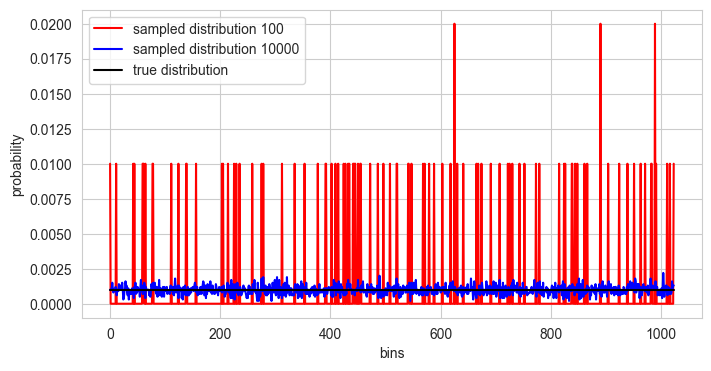

In [9]:
# insert your code here 

# ------------------------------------
# Sample from the uniform distribution
# using sample size of 100 (0.5 pts)
# ------------------------------------
uniform_samples = np.random.choice(N, size=100, p=p)
#uniform_samples = np.random.randint(low=0, high=D ,size=100)    

# ------------------------------------
# Sample from the uniform distribution
# using sample size of 10000 (0.5 pts)
# ------------------------------------
uniform_samples_2 = np.random.choice(N, size=10000, p=p)

#uniform_samples_2 = np.random.randint(low=0, high=D ,size=10000)

# ------------------------------------
# Plot the true distribution and 
# the sampled distributions. (0.5 pts)
# ------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# plot the true distribution

# plot the sampled distribution
ax.plot(np.histogram(uniform_samples, bins=N)[0] / 100, 'r', label='sampled distribution 100')
ax.plot(np.histogram(uniform_samples_2, bins=N)[0] / 10000, 'b', label='sampled distribution 10000')
ax.plot(p, 'k', label='true distribution')

ax.set_xlabel('bins')
ax.set_ylabel('probability')
ax.legend(loc='best')

# we noticed that the sampled distribution is not as smooth as the true distribution because the sample size is not large enough, 
# but if you would to enlarge the sample size, the sampled distribution will be more smooth and close to the true distribution.



Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [10]:
sample_sizes = np.round(np.logspace(1,5,num=10))
n_runs = 30

edges = np.arange(-0.5, N, 1) 

h_mle  = np.zeros((len(sample_sizes), n_runs))
h_mm   = np.zeros((len(sample_sizes), n_runs))
h_jk   = np.zeros((len(sample_sizes), n_runs))
h_cae  = np.zeros((len(sample_sizes), n_runs))
h_jvhw = np.zeros((len(sample_sizes), n_runs))
h_unseen = np.zeros((len(sample_sizes), n_runs))

# add h_unseen or h_bub here if you implemented them.

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):
        
        # ------------------------------------
        # Sample from the uniform distribution
        # with different sample size (0.5 pts)
        # ------------------------------------  
        x = np.random.choice(N, size=int(S), p=p)
        phat = np.histogram(x, bins=edges)[0] / S
        # insert your code here  
        zip_h_mle[i,j]  = entropy_mle(phat)
        h_mm[i,j]   = entropy_mm(phat, S)
        h_cae[i,j]  = entropy_cae(phat, S)
        h_jk[i,j]   = entropy_jk(x, edges)
        h_jvhw[i,j] = entropy_jvhw(x)
        # add h_unseen or h_bub here if you implemented them.
        #h_unseen[i,j] = unseen(x)


/var/folders/6f/4s63gb612m185fbsprljhfmh0000gn/T/ipykernel_9254/1409420637.py:34: RuntimeWarning: invalid value encountered in divide
  H = -np.nansum(PCs / (1 - ((1 - PC) ** n)))
/var/folders/6f/4s63gb612m185fbsprljhfmh0000gn/T/ipykernel_9254/641789983.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h_jvhw[i,j] = entropy_jvhw(x)


Plot the resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

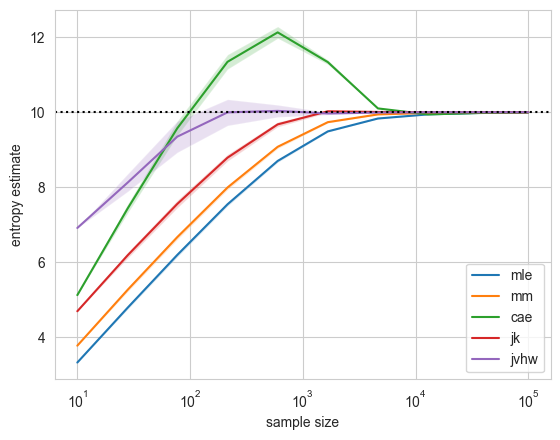

In [18]:
plt.figure()
plt.semilogx(sample_sizes, np.mean(h_mle,  axis=1), label='mle')
plt.fill_between(sample_sizes, np.mean(h_mle, axis=1) - np.std(h_mle, axis=1), np.mean(h_mle, axis=1) + np.std(h_mle, axis=1), alpha=0.2)
plt.semilogx(sample_sizes, np.mean(h_mm,   axis=1), label='mm')
plt.fill_between(sample_sizes, np.mean(h_mm, axis=1) - np.std(h_mm, axis=1), np.mean(h_mm, axis=1) + np.std(h_mm, axis=1), alpha=0.2)
plt.semilogx(sample_sizes, np.mean(h_cae,  axis=1), label='cae')
plt.fill_between(sample_sizes, np.mean(h_cae, axis=1) - np.std(h_cae, axis=1), np.mean(h_cae, axis=1) + np.std(h_cae, axis=1), alpha=0.2)
plt.semilogx(sample_sizes, np.mean(h_jk,   axis=1), label='jk')
plt.fill_between(sample_sizes, np.mean(h_jk, axis=1) - np.std(h_jk, axis=1), np.mean(h_jk, axis=1) + np.std(h_jk, axis=1), alpha=0.2)
plt.semilogx(sample_sizes, np.mean(h_jvhw, axis=1), label='jvhw')
plt.fill_between(sample_sizes, np.mean(h_jvhw, axis=1) - np.std(h_jvhw, axis=1), np.mean(h_jvhw, axis=1) + np.std(h_jvhw, axis=1), alpha=0.2)

# plot h_unseen or h_bub here if you implemented them.

plt.axhline(H, color='black', linestyle=':')
plt.xlabel('sample size')
plt.ylabel('entropy estimate')
plt.legend()


### Zipf distribution

[Zipf's law ](https://en.wikipedia.org/wiki/Zipf%27s_law) refers to a family of power law like distributions for which $p_k \sim 1/k^d$. We will simply use $d=1$ here.   

Adapt the framework above to sample from a Zipf distribution and evaluate the estimators for this case. Are there differences to the uniform case? (2 pts)

In [22]:
D = 10
N = 2**D

p = 1/(np.arange(0,N)+1)    # true distribution
p = p/np.sum(p)

H_zipf = - np.sum(p * np.log2(p))  # true entropy

print(H_zipf)

7.510649703297878


Sample from the Zipf distribution using sample sizes of 100 and 10000. In this case, the function `random.choice` is very helpful for sampling. Plot the true distribution and the sampled distributions. What do you notice? 

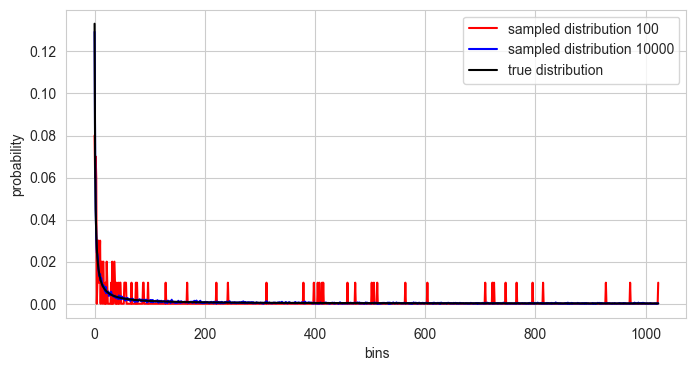

In [13]:
# insert your code here 

# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 100 (0.5 pts)
# ---------------------------------------
zipf_samples = np.random.choice(N, size=100, p=p)

# ---------------------------------------
# Sample from the Zipf distribution
# using sample size of 10000 (0.5 pts)
# ---------------------------------------
zipf_samples_2 = np.random.choice(N, size=10000, p=p)

# ---------------------------------------
# Plot the true distribution and the sampled
# distributions. (0.5 pts)
# ---------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# plot the true distribution

ax.plot(np.histogram(zipf_samples, bins=N)[0] / 100, 'r', label='sampled distribution 100')
ax.plot(np.histogram(zipf_samples_2, bins=N)[0] / 10000, 'b', label='sampled distribution 10000')
ax.plot(p, 'k', label='true distribution')
ax.set_xlabel('bins')
ax.set_ylabel('probability')
ax.legend(loc='best')


# we noticed that the sampled distribution is not as smooth as the true distribution because the sample size is not large enough,



Use the framework below to generate samples of different size (logarithmically spaced between 10 and 100000) and evaluate the different entropy estimators for multiple runs.

In [14]:
sample_sizes = np.round(np.logspace(1,5,num=10))
n_runs = 30

edges = np.arange(-0.5, N, 1)

zip_h_mle  = np.zeros((len(sample_sizes), n_runs))
zip_h_mm   = np.zeros((len(sample_sizes), n_runs))
zip_h_jk   = np.zeros((len(sample_sizes), n_runs))
zip_h_cae  = np.zeros((len(sample_sizes), n_runs))
zip_h_jvhw = np.zeros((len(sample_sizes), n_runs))

# add h_unseen or h_bub here if you implemented them.

for i, S in enumerate(sample_sizes):
    for j in np.arange(n_runs):
    
        # ---------------------------------------
        # Sample from the Zipf distribution
        # with different sample size (0.5 pts)
        # ---------------------------------------
        x = np.random.choice(N, size=int(S), p=p)
        phat = np.histogram(x, bins=edges)[0] / S

        # insert your code here   
        
        zip_h_mle[i,j]  = entropy_mle(phat)
        zip_h_mm[i,j]   = entropy_mm(phat, S)
        zip_h_cae[i,j]  = entropy_cae(phat, S)
        zip_h_jk[i,j]   = entropy_jk(x, edges)
        zip_h_jvhw[i,j] = entropy_jvhw(x)


/var/folders/6f/4s63gb612m185fbsprljhfmh0000gn/T/ipykernel_9254/1409420637.py:34: RuntimeWarning: invalid value encountered in divide
  H = -np.nansum(PCs / (1 - ((1 - PC) ** n)))
/var/folders/6f/4s63gb612m185fbsprljhfmh0000gn/T/ipykernel_9254/47445998.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zip_h_jvhw[i,j] = entropy_jvhw(x)


Plot resulting average estimate of the entropy for each of the estimators. Which is best? If you implemented everything correctly, this plot should roughly look like in the lecture.

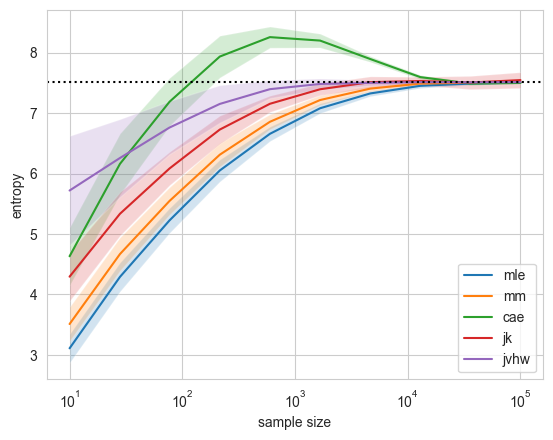

In [23]:
plt.figure()

plt.semilogx(sample_sizes, np.mean(zip_h_mle,  axis=1), label='mle')
# plot std error
plt.fill_between(sample_sizes, np.mean(zip_h_mle,  axis=1) - np.std(zip_h_mle,  axis=1), np.mean(zip_h_mle,  axis=1) + np.std(zip_h_mle,  axis=1), alpha=0.2)

plt.semilogx(sample_sizes, np.mean(zip_h_mm,   axis=1), label='mm')
plt.fill_between(sample_sizes, np.mean(zip_h_mm,  axis=1) - np.std(zip_h_mm,  axis=1), np.mean(zip_h_mm,  axis=1) + np.std(zip_h_mm,  axis=1), alpha=0.2)

plt.semilogx(sample_sizes, np.mean(zip_h_cae,  axis=1), label='cae')
plt.fill_between(sample_sizes, np.mean(zip_h_cae,  axis=1) - np.std(zip_h_cae,  axis=1), np.mean(zip_h_cae,  axis=1) + np.std(zip_h_cae,  axis=1), alpha=0.2)

plt.semilogx(sample_sizes, np.mean(zip_h_jk,   axis=1), label='jk')
plt.fill_between(sample_sizes, np.mean(zip_h_jk,  axis=1) - np.std(zip_h_jk,  axis=1), np.mean(zip_h_jk,  axis=1) + np.std(zip_h_jk,  axis=1), alpha=0.2)

plt.semilogx(sample_sizes, np.mean(zip_h_jvhw, axis=1), label='jvhw')
plt.fill_between(sample_sizes, np.mean(zip_h_jvhw,  axis=1) - np.std(zip_h_jvhw,  axis=1), np.mean(zip_h_jvhw,  axis=1) + np.std(zip_h_jvhw,  axis=1), alpha=0.2)

# plot h_unseen or h_bub here if you implemented them.
plt.ylabel('entropy')
plt.xlabel('sample size')
plt.axhline(H_zipf, color='black', linestyle=':')
plt.legend()



### Key differences between the two distributions:
* Zipfs law is a power law distribution, while the uniform distribution is a constant distribution, which means that the probability of each event is the same.
* The standard deviation in the plots are higher in the Zipf distribution than in the uniform distribution. 
* The Zipf distribution has a lower entropy than the uniform distribution.
* The esitmation starts at a lower entropy in the Zipf distribution than in the uniform distribution.
